<a href="https://colab.research.google.com/github/peremartra/Rearchitecting-LLMs/blob/main/CH04/CH04_NB0x_Cosine_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Rearchitecting LLMs
## Surgical Optimization for Hyper-Efficient Models


### Chapter 4: Depth Pruning: Building Smaller and Faster Models
by [Pere Martra](https://github.com/peremartra)

[![LinkedIn](https://img.shields.io/badge/LinkedIn-0077B5?style=flat&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/pere-martra/) [![GitHub](https://img.shields.io/badge/GitHub-100000?style=flat&logo=github&logoColor=white)](https://github.com/peremartra) [![X](https://img.shields.io/badge/X-000000?style=flat&logo=x&logoColor=white)](https://x.com/PereMartra) [![Hugging Face](https://img.shields.io/badge/🤗%20Hugging%20Face-blue)](https://huggingface.co/oopere)

_____
Colab Environment: GPU T4

Models:
* Qwen3-0.6B
_____

In this notebook we explore how to evaluate the contribution of different transformer blocks to the LLM’s objective using a dataset.

To do this, we use cosine similarity between the input and the output of the transformer block. The lower the similarity, the greater the modification that block has introduced to the data.

Blocks with higher similarity between input and output will be the candidates to be removed from the model.


# Setting up notebook

In [1]:
!pip install -q \
      "torch==2.8.0+cu126" \
      "transformers==4.55.4" \
      "accelerate==1.10.1" \
      "lm_eval==0.4.9.1" \
      "sentencepiece==0.2.1" \
      "sentence-transformers==5.1.0" \
      "optipfair==0.1.5"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 105.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 483.4/483.4 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from lm_eval import evaluator
from lm_eval.models.huggingface import HFLM
import os
import json
from optipfair import analyze_layer_importance, prune_model_depth, prune_model

In [3]:
# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA L4


In [4]:
def evaluate_metrics(model, dataloader, device='cuda'):
    model.eval()
    model.to(device)

    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluando"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Create labels, ignoring padding (-100 = ignore_index)
            labels = input_ids.clone()
            labels[attention_mask == 0] = -100

            # Forward pass
            outputs = model(
                input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            # Only real tokens (no padding)
            num_real_tokens = attention_mask.sum().item()

            total_loss += outputs.loss.item() * num_real_tokens
            total_tokens += num_real_tokens

    # metrics
    avg_loss = total_loss / total_tokens
    perplexity = np.exp(avg_loss)

    return {
        'loss': avg_loss,
        'perplexity': perplexity
    }

## Load Model

In [5]:
MODEL_NAME = 'Qwen/Qwen3-0.6B'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto"
)
model.eval()

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 1024)
    (layers): ModuleList(
      (0-27): 28 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=1024, out_features=2048, bias=False)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=1024, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (up_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (down_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
        (post_attention_layernorm): Qwe

## Load Datasets

In [6]:
RECOVERY_SAMPLES = 1000
BATCH_SIZE = 8
MAX_LENGTH = 512

We’re going to use two different datasets to visualize how some layers are more important than others depending on the data being used.

* **Wikitext**: Contains highly complex text. To process this kind of text, the model needs to rely on its deeper layers to understand context, semantic relations, and complex grammatical structures.
* **SMS Spam**: A completely different dataset, made up of short sentences with simple and direct language. It doesn’t require deep semantic understanding.


In [7]:
datawiki = load_dataset('wikitext', 'wikitext-2-raw-v1', split=f'train[:{RECOVERY_SAMPLES}]')

datasms = load_dataset('sms_spam', split=f'train[:{RECOVERY_SAMPLES}]')

README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/359k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5574 [00:00<?, ? examples/s]

In [8]:
def prepare_dataset(dataset, text_field='text'):
  def tokenize_function(examples):
      if text_field in examples:
          texts = examples[text_field]
      elif 'sms' in examples:  # SMS dataset
          texts = examples['sms']
      elif 'text' in examples:
          texts = examples['text']
      else:
          texts = examples[list(examples.keys())[0]]  # First available field

      return tokenizer(
          texts,
          truncation=True,
          padding='max_length',
          max_length=MAX_LENGTH,
          return_tensors='pt'
      )

  tokenized = dataset.map(tokenize_function, batched=True, remove_columns=dataset.column_names)
  tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask'])
  return DataLoader(tokenized, batch_size=BATCH_SIZE, shuffle=False)


In [9]:
# Crear dataloaders
dataloaderwiki = prepare_dataset(datawiki)  # WikiText (largo)
dataloadersms = prepare_dataset(datasms)  # SMS (corto)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

# 4.2 Block Selection Strategies
In this section, we're going to explore different strategies to make this decision. We'll start with the most direct and simple approaches, known as static or "data-free"



## 4.2.1 Static Approaches (Data-Free)
Static approaches are those based on analyzing the structure and initial weights of the model.

In [10]:
# Based in position.
from copy import deepcopy

num_layers = len(model.model.layers)  # 32
layers_to_keep = num_layers - 4
print(f"Number of layers: {num_layers}")
print(f"Layers to keep: {layers_to_keep}")

pruned_model = deepcopy(model)
pruned_model.model.layers = pruned_model.model.layers[:layers_to_keep]
print(f"Number of layers in pruned model: {len(pruned_model.model.layers)}")

Number of layers: 28
Layers to keep: 24
Number of layers in pruned model: 24


In [11]:
# Based in weigths
def calculate_layer_magnitude(layer):
    total_magnitude = 0
    for param in layer.parameters():
        total_magnitude += torch.norm(param).item()
    return total_magnitude

# Calculate magnitude for each layer
layer_magnitudes = []
for i, layer in enumerate(model.model.layers):
    magnitude = calculate_layer_magnitude(layer)
    layer_magnitudes.append((i, magnitude))

# Remove layers with lower magnitude
layer_magnitudes.sort(key=lambda x: x[1])  # Sort by magnitude
layers_to_remove = [idx for idx, _ in layer_magnitudes[:4]]  # Remove layers with lower

print(layers_to_remove)

[8, 2, 7, 6]


# 4.3 Data-driven analysis and pruning

To decide which layers to remove, we measure their contribution using cosine similarity. We chose this metric because it’s perfect for this task: it measures the change in semantic direction between the input and output vectors of a layer, ignoring their magnitude.

This gives us a normalized score that we convert into an importance score (1 - similarity).

A score close to zero identifies a “passive” layer that barely alters the information, making it an ideal candidate for removal.


## 4.3.1 Using PyTorch hooks







We define a simple function to use as a hook that shows the shape of the input tensor and the output tensor.

In [12]:
def print_shape_hook(module, input, output):
    """
    Hook function that prints tensor shapes
    module: the layer where the hook is attached
    input: tuple of input tensors to the layer
    output: the output tensor from the layer
    """
    # Input is a tuple, we take the first element (the hidden states)
    print(f"Module class: {module.__class__.__name__}")
    print(f"Module id: {id(module)}")
    input_tensor = input[0]
    print(f"Input shape:  {input_tensor.shape}")
    print(f"Output shape: {output.shape}")

We register the hook in the first transformer block.Retry

In [13]:
# Register the hook on the first transformer block
first_layer = model.model.layers[0]
hook_handle = first_layer.register_forward_hook(print_shape_hook)

We run a forward with the model and get the hook result that Pytorch executes automatically.

In [14]:
# Test with a simple input
test_text = "He sat on the river bank to fish"
inputs = tokenizer(test_text, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

Module class: Qwen3DecoderLayer
Module id: 138913032734048
Input shape:  torch.Size([1, 8, 1024])
Output shape: torch.Size([1, 8, 1024])


We remove the hooks.

In [15]:
# Remove the hook when done
hook_handle.remove()

If we run the forward again, the hook no longer executesRetry

In [16]:
with torch.no_grad():
    outputs = model(**inputs)

## 4.3.2 Understanding cosine similarity.

In [17]:
from sentence_transformers import SentenceTransformer
import torch
import torch.nn.functional as F

# Load standard sentence embedding model
modelst = SentenceTransformer('all-MiniLM-L6-v2')

# Three example sentences: two semantically similar, one different
sentences = [
    "The cat naps on the sofa.",
    "The feline is peacefully slumbering on the couch.",
    "The bus stops at the corner."
]

embeddings = modelst.encode(sentences, convert_to_tensor=True)

print(f"Embedding shape: {embeddings.shape}")
print(f"Each sentence is represented by {embeddings.shape[1]} dimensions\n")

# Calculate cosine similarity matrix using PyTorch
# We need to compute all pairs, so we use matrix multiplication
# First normalize embeddings
embeddings_normalized = F.normalize(embeddings, p=2, dim=1)

# Compute similarity matrix (cosine = dot product of normalized vectors)
similarity_matrix = torch.mm(embeddings_normalized, embeddings_normalized.T)

print("Cosine Similarity Matrix:")
print(similarity_matrix)
print("\nInterpretation:")
print(f"Sentence 1 vs Sentence 2: {similarity_matrix[0][1]:.4f} (semantically similar)")
print(f"Sentence 1 vs Sentence 3: {similarity_matrix[0][2]:.4f} (different topics)")
print("\nNote: Values close to 1.0 indicate high similarity")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding shape: torch.Size([3, 384])
Each sentence is represented by 384 dimensions

Cosine Similarity Matrix:
tensor([[1.0000, 0.6106, 0.0563],
        [0.6106, 1.0000, 0.0504],
        [0.0563, 0.0504, 1.0000]], device='cuda:0')

Interpretation:
Sentence 1 vs Sentence 2: 0.6106 (semantically similar)
Sentence 1 vs Sentence 3: 0.0563 (different topics)

Note: Values close to 1.0 indicate high similarity


## 4.3.3 Analyzing block bontributions across different datasets


To capture the input and output of the layers we use PyTorch hooks, which let us study/spy on the model’s behavior.


In [18]:
def setup_layer_hooks(model):
    """
    Register hooks to capture input/output of each transformer layer
    Returns: hooks list and storage dictionaries
    """
    num_layers = len(model.model.layers)
    layer_inputs = {}
    layer_outputs = {}
    hooks = []

    def create_hook(layer_idx): #B
        def hook(module, input, output): #C
            input_tensor = input[0] if isinstance(input, tuple) else input
            layer_inputs[layer_idx] = input_tensor.detach() #D

            output_tensor = output[0] if isinstance(output, tuple) else output
            layer_outputs[layer_idx] = output_tensor.detach() #D
        return hook

    # Register hooks for each layer
    for i, layer in enumerate(model.model.layers):
        hooks.append(
            layer.register_forward_hook(create_hook(i))
            )

    return hooks, layer_inputs, layer_outputs, num_layers

### Calculate Cosine Similarity

In [19]:
def calculate_cosine_importance(input_tensor, output_tensor, layer_idx, is_first_batch=False):
    """
    Calculate importance score using cosine similarity between input and output tensors.
    Optimized for GPU by computing similarity on full batch before filtering.

    Args:
        input_tensor: Input hidden states to the layer
        output_tensor: Output hidden states from the layer
        layer_idx: Layer index for debugging
        is_first_batch: Whether to print debug warnings

    Returns:
        importance: Score from 0.0 to 1.0 (higher = more important)
    """
    # Validate tensor dimensions
    if input_tensor.numel() == 0 or output_tensor.numel() == 0:
        return 0.0

    # Flatten tensors to [batch_size, features]
    input_flat = input_tensor.view(input_tensor.size(0), -1)
    output_flat = output_tensor.view(output_tensor.size(0), -1)

    # Compute cosine similarity for entire batch (GPU-optimized)
    similarities = F.cosine_similarity(input_flat, output_flat, dim=1)

    # Filter non-finite values after computation
    finite_similarities = similarities[torch.isfinite(similarities)]

    # Handle case with no valid samples
    if finite_similarities.numel() == 0:
        if is_first_batch:
            print(f"Warning: Layer {layer_idx} produced all inf/nan similarities")
        return 0.0

    # Importance = 1 - average similarity
    # (low similarity = high change = high importance)
    importance = 1.0 - finite_similarities.mean().item()

    return importance

We aggregate the results

This function takes the importance scores collected from all data batches for each layer. Then, it computes the average of these scores to get a single final consolidated importance score for each layer of the model.

In [20]:
def calculate_layer_importance_cosine(model, dataloader, device):
    """
    Calculate layer importance using cosine similarity between input/output representations

    Args:
        model: Transformer model
        dataloader: DataLoader with tokenized text data
        device: torch device (cuda/cpu)

    Returns:
        dict: Layer importance scores {layer_idx: importance_score}
    """
    # Setup hooks and storage
    hooks, layer_inputs, layer_outputs, num_layers = setup_layer_hooks(model)
    layer_importance_scores = {i: [] for i in range(num_layers)}

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader,
                                               desc="Processing batches")):
            inputs = {k: v.to(device) for k, v in batch.items()}

            # Forward pass to trigger hooks
            model(**inputs)

            # Calculate importance for each layer
            for layer_idx in range(num_layers):
                if layer_idx not in layer_inputs or layer_idx not in layer_outputs:
                    raise RuntimeError(f"Layer {layer_idx} Hook failed.")


                importance = calculate_cosine_importance(
                    layer_inputs[layer_idx],
                    layer_outputs[layer_idx],
                    layer_idx)

                layer_importance_scores[layer_idx].append(importance)

            # Clear storage for next batch
            layer_inputs.clear()
            layer_outputs.clear()

    # Cleanup hooks
    [hook.remove() for hook in hooks]

    # Aggregate final scores
    final_scores = {}

    for layer_idx, scores in layer_importance_scores.items():
      valid_scores = [s for s in scores if np.isfinite(s)]
      if not valid_scores:
          raise RuntimeError(f"Layer {layer_idx} not captured. Hook failed.")
      else:
          final_scores[layer_idx] = np.mean(valid_scores)

    return final_scores

### Obtaining & Studying results

In [21]:
def print_sorted_importance(scores):
    for i, (layer, score) in enumerate(sorted(scores.items(), key=lambda x: float(x[1]), reverse=True), 1):
        print(f"Layer {layer:2d}: {float(score):.6f}")

In [22]:
wiki_importance= calculate_layer_importance_cosine(
    model,
    dataloaderwiki,
    device)

Processing batches: 100%|██████████| 125/125 [00:26<00:00,  4.71it/s]


In [23]:
print_sorted_importance(wiki_importance)

Layer  0: 0.873564
Layer  2: 0.688214
Layer  1: 0.331604
Layer 27: 0.185090
Layer 23: 0.114152
Layer 25: 0.100961
Layer 24: 0.095664
Layer 22: 0.092551
Layer 17: 0.086270
Layer 26: 0.082996
Layer 21: 0.079297
Layer  4: 0.074676
Layer 19: 0.073289
Layer 16: 0.072957
Layer 11: 0.072863
Layer  9: 0.071211
Layer 13: 0.069551
Layer  5: 0.068758
Layer  6: 0.067988
Layer  3: 0.064387
Layer 14: 0.064340
Layer 15: 0.064215
Layer 12: 0.063137
Layer 10: 0.062883
Layer  8: 0.057531
Layer 20: 0.053785
Layer 18: 0.051473
Layer  7: 0.047656


In [24]:
sms_importance = calculate_layer_importance_cosine(
    model,
    dataloadersms,
    device)

Processing batches: 100%|██████████| 125/125 [00:27<00:00,  4.57it/s]


In [25]:
print_sorted_importance(sms_importance)

Layer  2: 0.948956
Layer  0: 0.896829
Layer  1: 0.278109
Layer 27: 0.146457
Layer 21: 0.025656
Layer 24: 0.023531
Layer 25: 0.021184
Layer 22: 0.017563
Layer 26: 0.017063
Layer 20: 0.016910
Layer 19: 0.016129
Layer 23: 0.015055
Layer 18: 0.009148
Layer 17: 0.006742
Layer 16: 0.006316
Layer 15: 0.005473
Layer 14: 0.005441
Layer 10: 0.005352
Layer 11: 0.004922
Layer 12: 0.004199
Layer 13: 0.003980
Layer  9: 0.003898
Layer  8: 0.003418
Layer  7: 0.003004
Layer  6: 0.002879
Layer  5: 0.002410
Layer  4: 0.001961
Layer  3: 0.001453


In [26]:
def compare_importance(scores1, scores2, name1="Dataset1", name2="Dataset2"):
    print(f"{'Layer':<5} {name1:<10} {name2:<10} {'Diff':<8}")
    print("-" * 35)
    for layer in sorted(scores1.keys()):
        s1, s2 = float(scores1[layer]), float(scores2[layer])
        diff = abs(s1 - s2)
        print(f"{layer:<5} {s1:<10.4f} {s2:<10.4f} {diff:<8.4f}")

In [27]:
compare_importance(wiki_importance, sms_importance, "wiki", "SMS")

Layer wiki       SMS        Diff    
-----------------------------------
0     0.8736     0.8968     0.0233  
1     0.3316     0.2781     0.0535  
2     0.6882     0.9490     0.2607  
3     0.0644     0.0015     0.0629  
4     0.0747     0.0020     0.0727  
5     0.0688     0.0024     0.0663  
6     0.0680     0.0029     0.0651  
7     0.0477     0.0030     0.0447  
8     0.0575     0.0034     0.0541  
9     0.0712     0.0039     0.0673  
10    0.0629     0.0054     0.0575  
11    0.0729     0.0049     0.0679  
12    0.0631     0.0042     0.0589  
13    0.0696     0.0040     0.0656  
14    0.0643     0.0054     0.0589  
15    0.0642     0.0055     0.0587  
16    0.0730     0.0063     0.0666  
17    0.0863     0.0067     0.0795  
18    0.0515     0.0091     0.0423  
19    0.0733     0.0161     0.0572  
20    0.0538     0.0169     0.0369  
21    0.0793     0.0257     0.0536  
22    0.0926     0.0176     0.0750  
23    0.1142     0.0151     0.0991  
24    0.0957     0.0235     0.0721  
25

In [28]:
import matplotlib.pyplot as plt

def compare_importance(scores1, scores2, name1="Dataset1", name2="Dataset2",
                      start=None, end=None, model="Qwen3-0.6B"):
    layers = sorted(scores1.keys())
    if start is not None or end is not None:
        layers = [l for l in layers if (start is None or l >= start) and
                 (end is None or l <= end)]

    vals1 = [float(scores1[l]) for l in layers]
    vals2 = [float(scores2[l]) for l in layers]

    x = np.arange(len(layers))
    width = 0.35

    plt.figure(figsize=(10, 4))
    plt.bar(x - width/2, vals1, width, label=name1, alpha=0.7)
    plt.bar(x + width/2, vals2, width, label=name2, alpha=0.7)

    plt.xlabel('Transformer Block')
    plt.ylabel('Cosine Distance')
    plt.xticks(x, layers)
    plt.legend()
    plt.title(f"Transformer Block Importance on {model}: SMS vs. WikiText")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

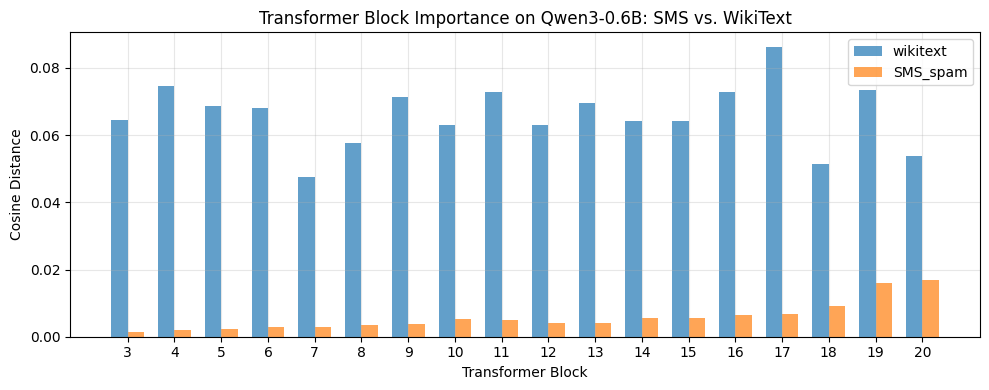

In [29]:
compare_importance(wiki_importance, sms_importance, name1="wikitext", name2="SMS_spam", start=3, end=20)

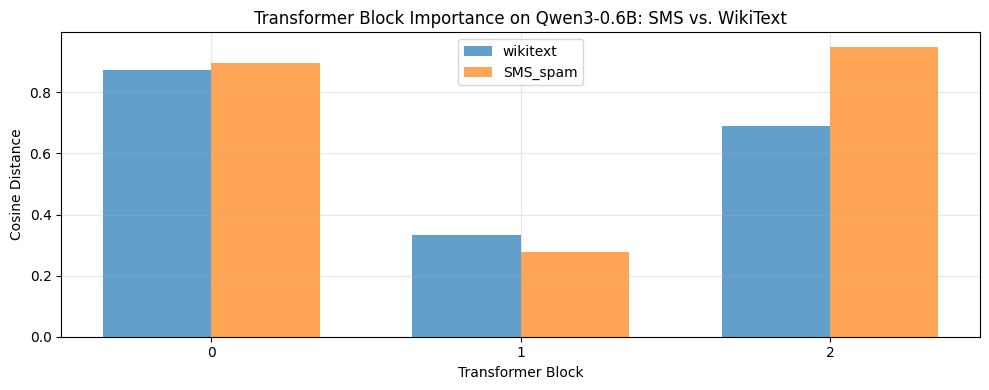

In [30]:
compare_importance(wiki_importance, sms_importance, name1="wikitext", name2="SMS_spam", start=0, end=2)

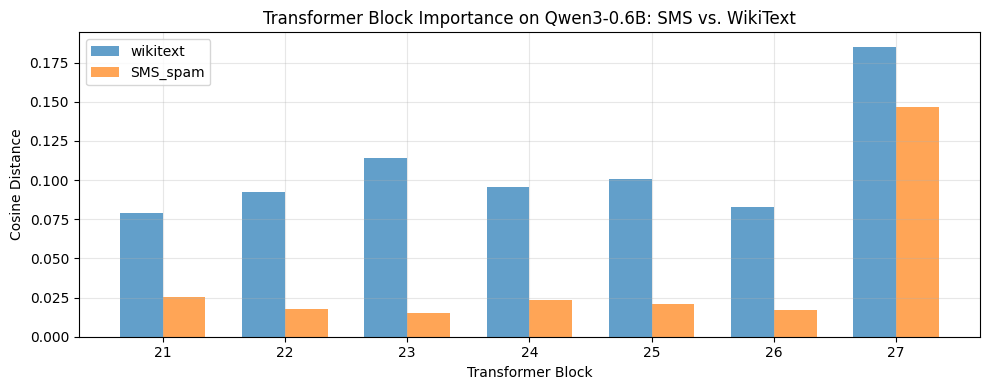

In [31]:
compare_importance(wiki_importance, sms_importance, name1="wikitext", name2="SMS_spam", start=21, end=27)

The results of our comparison reveal a clear pattern. The first layers (0–2) and the last one (27) prove to be important in both datasets, suggesting that they perform fundamental functions, such as the initial processing of the input and the consolidation of the output.

The key difference lies in the behavior of the intermediate layers (roughly 3–26). While in the complex text of Wikitext these layers carry out a measurable job of semantic refinement, in the simple SMS text their contribution is practically null, becoming “passive.” This shows that the importance of a layer varies depending on the complexity of the task, thus validating “depth pruning” as an effective strategy to create more efficient models for specialized tasks.


### Creating models using optipfair.

We'll create a function to select the blocks to delete.

This function can use the protection heuristic, always keeping the first four blocks and the last two. It will also avoid deleting two consecutive blocks.


In [32]:
def select_layers_to_prune(importance_scores,
                           num_layers=2,
                           heuristic_protection=True,
                           adjacent_protection=True):
    """
    Selecciona capas siguiendo mejores prácticas:
    - No consecutivas
    - Distribuidas en el modelo
    - Evitar capas muy tempranas (0-2) y última (27)
    """
    # Order by importance
    sorted_layers = sorted(importance_scores.items(), key=lambda x: x[1])

    selected = []
    for layer, score in sorted_layers:
        # Skip protected layers
        if heuristic_protection and layer in [0, 1, 2, 3, 27]:  # Primeras y última
            continue

        # Skip if adjacent
        if adjacent_protection and any(abs(layer - l) == 1 for l in selected):
            continue

        selected.append(layer)

        if len(selected) >= num_layers:
            break

    return selected

In [33]:
wiki_scores = analyze_layer_importance(model,
                                       dataloaderwiki,
                                       show_progress=True)

Processing batches: 100%|██████████| 125/125 [00:28<00:00,  4.43it/s]


In [34]:
wiki_layers_2_remove = select_layers_to_prune(wiki_scores, num_layers=3)
print (wiki_layers_2_remove)

[7, 18, 20]


In [35]:
wiki_model = prune_model(
        model=deepcopy(model),
        pruning_type="DEPTH",
        layer_indices=wiki_layers_2_remove,
        show_progress=True,
    )

Removing layers: 100%|██████████| 28/28 [00:00<00:00, 453438.27it/s]


In [36]:
sms_layers_2_remove = select_layers_to_prune(sms_importance, num_layers=3)
print (sms_layers_2_remove)

[4, 6, 8]


In [37]:
sms_model = prune_model(
        model=deepcopy(model),
        pruning_type="DEPTH",
        layer_indices=sms_layers_2_remove,
        show_progress=True,
    )

Removing layers: 100%|██████████| 28/28 [00:00<00:00, 471648.64it/s]


In [38]:
wiki_model

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 1024)
    (layers): ModuleList(
      (0-24): 25 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=1024, out_features=2048, bias=False)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=1024, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (up_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (down_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
        (post_attention_layernorm): Qwe

### Measuring Loss & Perplexity over SMS_Spam

In [39]:
metrics_base_sms = evaluate_metrics(model, dataloadersms)
metrics_sms_sms = evaluate_metrics(sms_model, dataloadersms)
metrics_wiki_sms = evaluate_metrics(wiki_model, dataloadersms)

Evaluando: 100%|██████████| 125/125 [00:30<00:00,  4.06it/s]


In [40]:
metrics_base_sms

{'loss': 5.614421927900561, 'perplexity': np.float64(274.354736527813)}

In [41]:
metrics_sms_sms

{'loss': 6.006728450055035, 'perplexity': np.float64(406.15239651873134)}

In [42]:
metrics_wiki_sms

{'loss': 6.095358391694976, 'perplexity': np.float64(443.7930684291305)}

In [43]:
model

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 1024)
    (layers): ModuleList(
      (0-27): 28 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=1024, out_features=2048, bias=False)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=1024, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (up_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (down_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
        (post_attention_layernorm): Qwe

In [44]:


metrics_base_wiki = evaluate_metrics(model, dataloaderwiki)
metrics_wiki_wiki = evaluate_metrics(wiki_model, dataloaderwiki)
metrics_sms_wiki = evaluate_metrics(sms_model, dataloaderwiki)

Evaluando: 100%|██████████| 125/125 [00:30<00:00,  4.13it/s]


In [45]:
metrics_base_wiki

{'loss': 3.720063090449313, 'perplexity': np.float64(41.26699757990196)}

In [46]:
metrics_wiki_wiki

{'loss': 4.408760701510063, 'perplexity': np.float64(82.16757023344248)}

In [47]:
metrics_sms_wiki

{'loss': 4.503326356815104, 'perplexity': np.float64(90.31705895534927)}

## Measuring general benchmarks

In [48]:
def model_evaluation(model_obj, tokenizer, tasks, limit=100):
    """
    Runs lm-eval on a PyTorch model object already in memory.

    Args:
        model_obj: The PyTorch model object to evaluate.
        tokenizer: The tokenizer object.
        tasks (list): A list of task names.
        limit (int): The number of samples per task.
    """
    print(f"Starting lm-eval on model '{model_obj.config._name_or_path}' for tasks: {tasks}")

    # Wrap the local model object and tokenizer for lm-eval
    model_wrapper = HFLM(
        pretrained=model_obj,
        tokenizer=tokenizer,
        device=str(device)
    )

    results = evaluator.simple_evaluate(
        model=model_wrapper,
        tasks=tasks,
        num_fewshot=0,
        limit=limit,
        device=str(device),
        #confirm_run_unsafe_code=True
    )

    # Format results for clean display
    formatted_results = {}
    for task_name, res in results["results"].items():
        # Look for accuracy ('acc') first, then perplexity ('ppl')
        if 'acc,none' in res:
            metric_val = res.get('acc,none', 0)
        elif 'ppl,none' in res:
             metric_val = res.get('ppl,none', 0)
        else:
            metric_val = 0 # Fallback

        formatted_results[task_name] = f"{metric_val:.4f}"

    print(json.dumps(formatted_results, indent=2))
    return formatted_results

In [53]:
benchmark_tasks = ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai']

In [54]:
os.environ["HF_ALLOW_CODE_EVAL"] = "1"
sms_model_results = model_evaluation(sms_model, tokenizer, benchmark_tasks, limit=100)

Starting lm-eval on model 'Qwen/Qwen3-0.6B' for tasks: ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai']


ARC-Easy/train-00000-of-00001.parquet:   0%|          | 0.00/331k [00:00<?, ?B/s]

ARC-Easy/test-00000-of-00001.parquet:   0%|          | 0.00/346k [00:00<?, ?B/s]

ARC-Easy/validation-00000-of-00001.parqu(…):   0%|          | 0.00/86.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2251 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2376 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/570 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

winogrande_xl/train-00000-of-00001.parqu(…):   0%|          | 0.00/2.06M [00:00<?, ?B/s]

winogrande_xl/test-00000-of-00001.parque(…):   0%|          | 0.00/118k [00:00<?, ?B/s]

winogrande_xl/validation-00000-of-00001.(…):   0%|          | 0.00/85.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/40398 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1767 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1267 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/24.4M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/6.11M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/6.32M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/39905 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10042 [00:00<?, ? examples/s]

Map:   0%|          | 0/39905 [00:00<?, ? examples/s]

Map:   0%|          | 0/10042 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

default/test/default.parquet:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/5153 [00:00<?, ? examples/s]

Running loglikelihood requests: 100%|██████████| 1099/1099 [00:39<00:00, 28.14it/s]


bootstrapping for stddev: perplexity


100%|██████████| 100/100 [00:00<00:00, 611.72it/s]


{
  "arc_easy": "0.3800",
  "hellaswag": "0.3500",
  "lambada_openai": "0.1600",
  "winogrande": "0.5100"
}


In [55]:
wiki_model_results = model_evaluation(wiki_model, tokenizer, benchmark_tasks, limit=100)

Starting lm-eval on model 'Qwen/Qwen3-0.6B' for tasks: ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai']


Running loglikelihood requests: 100%|██████████| 1099/1099 [00:39<00:00, 27.53it/s]


bootstrapping for stddev: perplexity


100%|██████████| 100/100 [00:00<00:00, 589.76it/s]


{
  "arc_easy": "0.5000",
  "hellaswag": "0.3800",
  "lambada_openai": "0.2400",
  "winogrande": "0.5000"
}
